Bộ dữ liệu chứa thông tin hai tháng về tất cả các yêu cầu HTTP gửi đến máy
chủ WWW của 1 công ty. Nhật ký đầu tiên được thu thập từ 00:00:00 ngày 1
tháng 7 năm 1995 đến 23:59:59 ngày 31 tháng 7 năm 1995, tổng cộng là 31
ngày. Nhật ký thứ hai được thu thập từ 00:00:00 ngày 1 tháng 8 năm 1995 đến
23:59:59 ngày 31 tháng 8 năm 1995, tổng cộng là 31 ngày. Các dấu thời gian có
độ phân giải 1 giây. Lưu ý rằng từ 14:52:01 ngày 01/08/1995 đến 04:36:13 ngày
03/08/1995 không có truy cập nào được ghi lại, do máy chủ Web đã bị tắt vì
Bão.
- Thành phần dữ liệu:Dữ liệu gốc ở định dạng ASCII, với mỗi dòng tương ứng
một yêu cầu. Thí sinh cần xử lý và trích xuất các trường thông tin:


- Host (Nguồn): Địa chỉ IP hoặc tên miền của máy khách gửi yêu cầu (Ví
dụ: 199.72.81.55).
- Timestamp (Thời gian): Thời điểm yêu cầu được ghi nhận (Ví dụ:
[01/Jul/1995:00:00:01 -0400]). Đây là trường quan trọng nhất để tạo
chuỗi thời gian.
- Request (Yêu cầu): Chứa phương thức (GET/POST), đường dẫn tài
nguyên (URL) và giao thức (Ví dụ: "GET /history/apollo/ HTTP/1.0").
- HTTP Reply Code (Trạng thái): Mã phản hồi từ máy chủ.
- Bytes in the reply (Kích thước): Dung lượng dữ liệu trả về.
- Quy định chia tập dữ liệu (Train/Test Split)
- Tập Huấn luyện (Train Set): Dữ liệu của tháng 7 và 22 ngày đầu tiên
của tháng 8.
- Tập Kiểm thử (Test Set): Dữ liệu của các ngày còn lại trong tháng 8.
- Yêu cầu tiền xử lý (Ingest + EDA):
- Pipeline đọc log, chuẩn hóa timestamp, parse fields (IP, URL, status).
- Khai thác time series: hits/sec, error rate, spike detection.

| Status                             | Meaning                         | What it means in your data                                                                         |
| ---------------------------------- | ------------------------------- | -------------------------------------------------------------------------------------------------- |
| **200 OK**                         | Request succeeded               | The page or API endpoint was returned correctly.                                                   |
| **304 Not Modified**               | Cached version is still valid   | The client already had the resource and the server said “no change”. Common for static files.      |
| **302 Found (Temporary Redirect)** | Redirect to another URL         | The server redirected the user (e.g., login, HTTPS redirect, or URL change).                       |
| **404 Not Found**                  | Resource does not exist         | Broken links, missing pages, bad URLs, or crawlers probing random paths.                           |
| **403 Forbidden**                  | Access denied                   | The client is blocked or lacks permission (IP blocked, auth required).                             |
| **500 Internal Server Error**      | Server crashed while processing | Bug, memory error, timeout, or bad backend logic.                                                  |
| **501 Not Implemented**            | Method not supported            | The server doesn’t recognize the request method (e.g., PUT on a server that only allows GET/POST). |
| **400 Bad Request**                | Malformed request               | Invalid syntax, missing parameters, or corrupted requests.                               

After Normalized: 

200 -> Success

304 -> No Change

302 -> Redirected

404 -> Not Found

Others -> Error

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

cwd = os.getcwd()

if not cwd.endswith("eda"):
    raise ValueError("Wrong path, should be in eda folder")

BASE_DIR = os.path.join(cwd, "..")

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

processed_dir = os.path.join(BASE_DIR, "data", "processed")

# Load data
df = pd.read_csv(os.path.join(processed_dir, "train.csv"))

# test_df = pd.read_csv(os.path.join(processed_dir, "test.csv"))


In [4]:
# Preprocessing: Convert time to datetime index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.sort_index(inplace=True)
df['status'] = df['status'].astype(str)

print(f"Train Shape: {df.shape}")
# print(f"Test Shape: {test_df.shape}")

Train Shape: (2934932, 10)


In [5]:
df.head(5)

,ip,identd,user,request,status,size,resource,protocol,utc,status_label
time,,,,,,,,,,
1995-07-01 00:00:01,199.72.81.55,-,-,GET /history/apollo/ HTTP/1.0,200,6245.0,/history/apollo/,HTTP/1.0,UTC - 04,Success
1995-07-01 00:00:06,unicomp6.unicomp.net,-,-,GET /shuttle/countdown/ HTTP/1.0,200,3985.0,/shuttle/countdown/,HTTP/1.0,UTC - 04,Success
1995-07-01 00:00:09,199.120.110.21,-,-,GET /shuttle/missions/sts-73/mission-sts-73.ht...,200,4085.0,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,UTC - 04,Success
1995-07-01 00:00:11,burger.letters.com,-,-,GET /shuttle/countdown/liftoff.html HTTP/1.0,304,0.0,/shuttle/countdown/liftoff.html,HTTP/1.0,UTC - 04,No Change
1995-07-01 00:00:11,199.120.110.21,-,-,GET /shuttle/missions/sts-73/sts-73-patch-smal...,200,4179.0,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,UTC - 04,Success


In [6]:
df.columns

Index(['ip', 'identd', 'user', 'request', 'status', 'size', 'resource',
       'protocol', 'utc', 'status_label'],
      dtype='object')

In [7]:
FIG_SIZE = (20, 5)

In [8]:
# df.resample('5T').size().plot(figsize = FIG_SIZE)

## EDA

### Macro level Overview


/var/folders/wj/8406k4zs34b1rtmbdltdknl00000gp/T/ipykernel_82725/866376337.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.resample('15T').size().plot(figsize = FIG_SIZE)
/var/folders/wj/8406k4zs34b1rtmbdltdknl00000gp/T/ipykernel_82725/866376337.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.resample('1H').size().plot(figsize = FIG_SIZE)


<Axes: xlabel='time'>

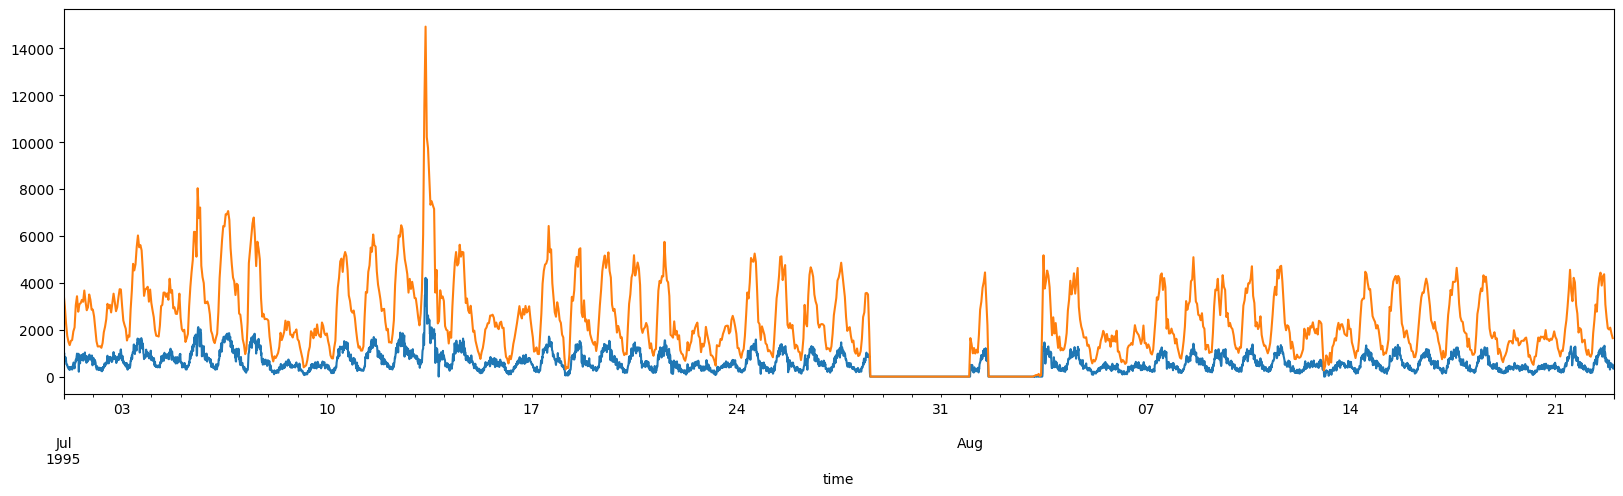

In [9]:
df.resample('15T').size().plot(figsize = FIG_SIZE)
df.resample('1H').size().plot(figsize = FIG_SIZE)

In [34]:
from plot_utils import print_macro_overview

print_macro_overview(df)


           MACRO DATASET OVERVIEW           
Time Range     : 1995-07-01 00:00:01 to 1995-08-22 23:59:59
Duration       : 52 Days
--------------------------------------------------
Total Requests : 2,934,932
Avg Daily Hits : 56,441
--------------------------------------------------
Total Traffic  : 53.07 GB
Avg Daily MB   : 1045.09 MB
--------------------------------------------------
Unique Users   : 121,246
Avg Req/User   : 24.21
--------------------------------------------------
Error Rate     : 9.97% (292,521 failed requests)


### Temporal Patterns

#### Total request counts by time interval in a week

/Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/Meine Ablage/03_PersonalWork/FomoKaguya2026/eda/plot_utils.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = df.resample(interval).size()


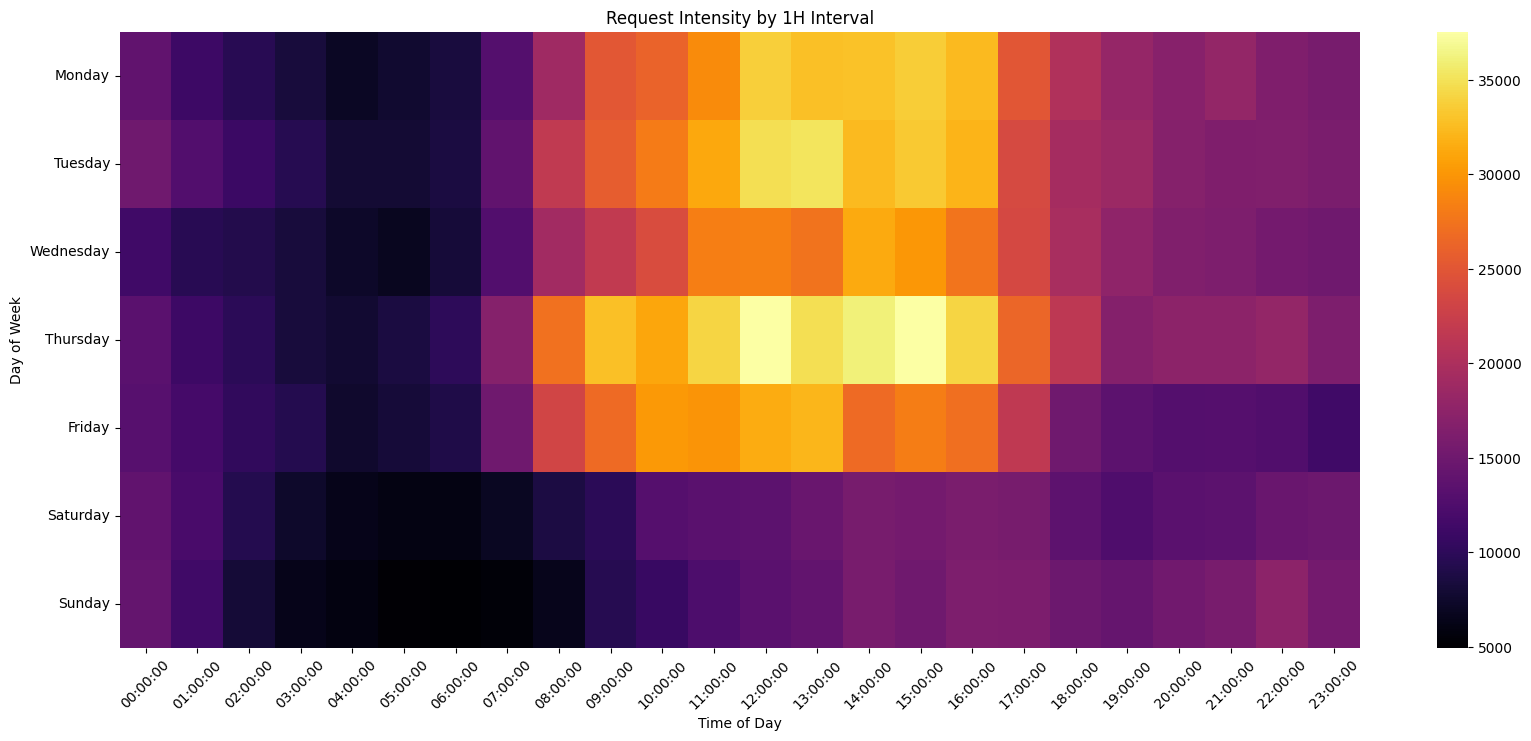

/Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/Meine Ablage/03_PersonalWork/FomoKaguya2026/eda/plot_utils.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = df.resample(interval).size()


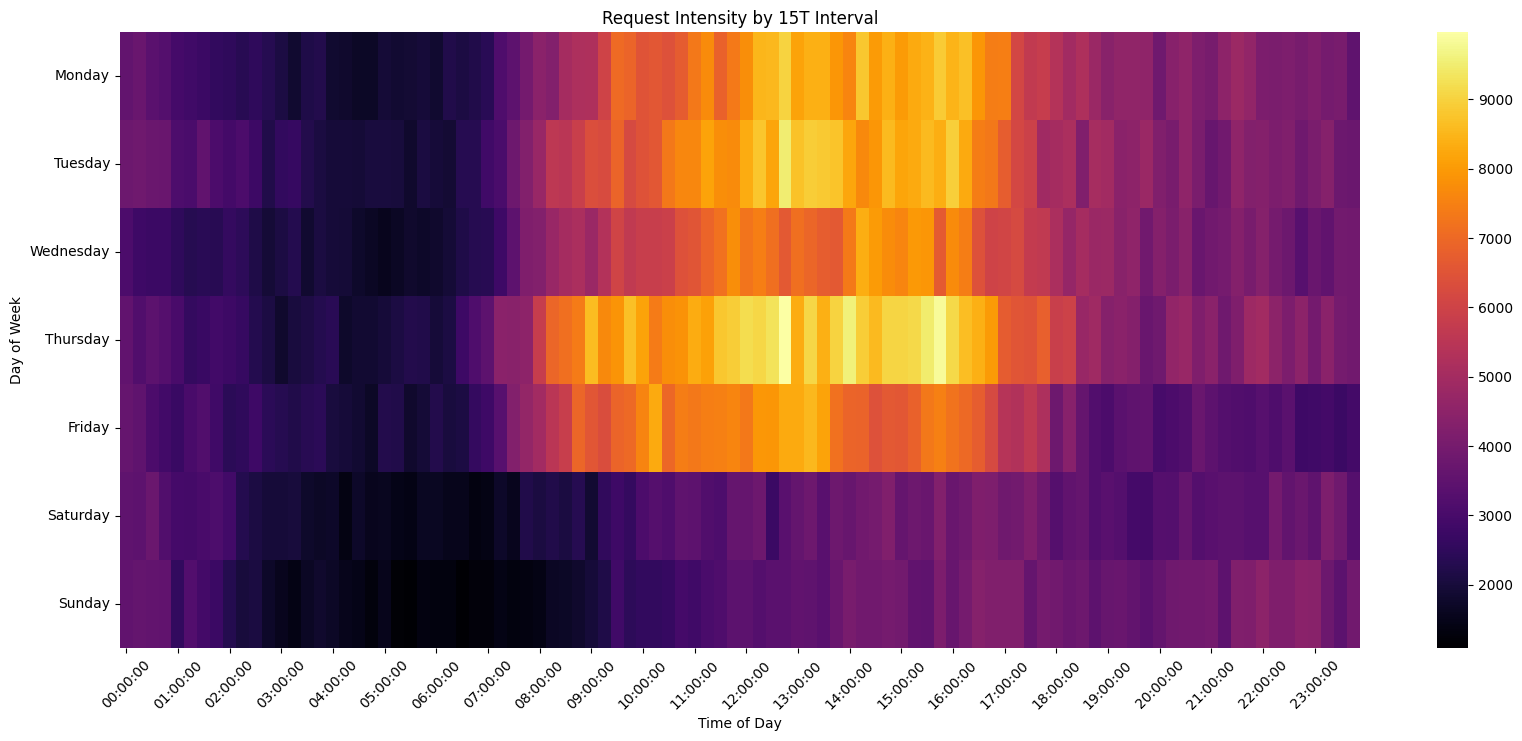

In [10]:
from plot_utils import plot_weekly_heatmap

plot_weekly_heatmap(df, '1H')
plot_weekly_heatmap(df, '15T')

del plot_weekly_heatmap

#### Mean success ratio, total file size, total hits per day of week and time of day

Processing data for 15T patterns...


/Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/Meine Ablage/03_PersonalWork/FomoKaguya2026/eda/plot_utils.py:133: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = df.resample(interval)
/Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/Meine Ablage/03_PersonalWork/FomoKaguya2026/eda/plot_utils.py:145: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts_success = df[df['status_label'] == 'Success'].resample(interval).size()


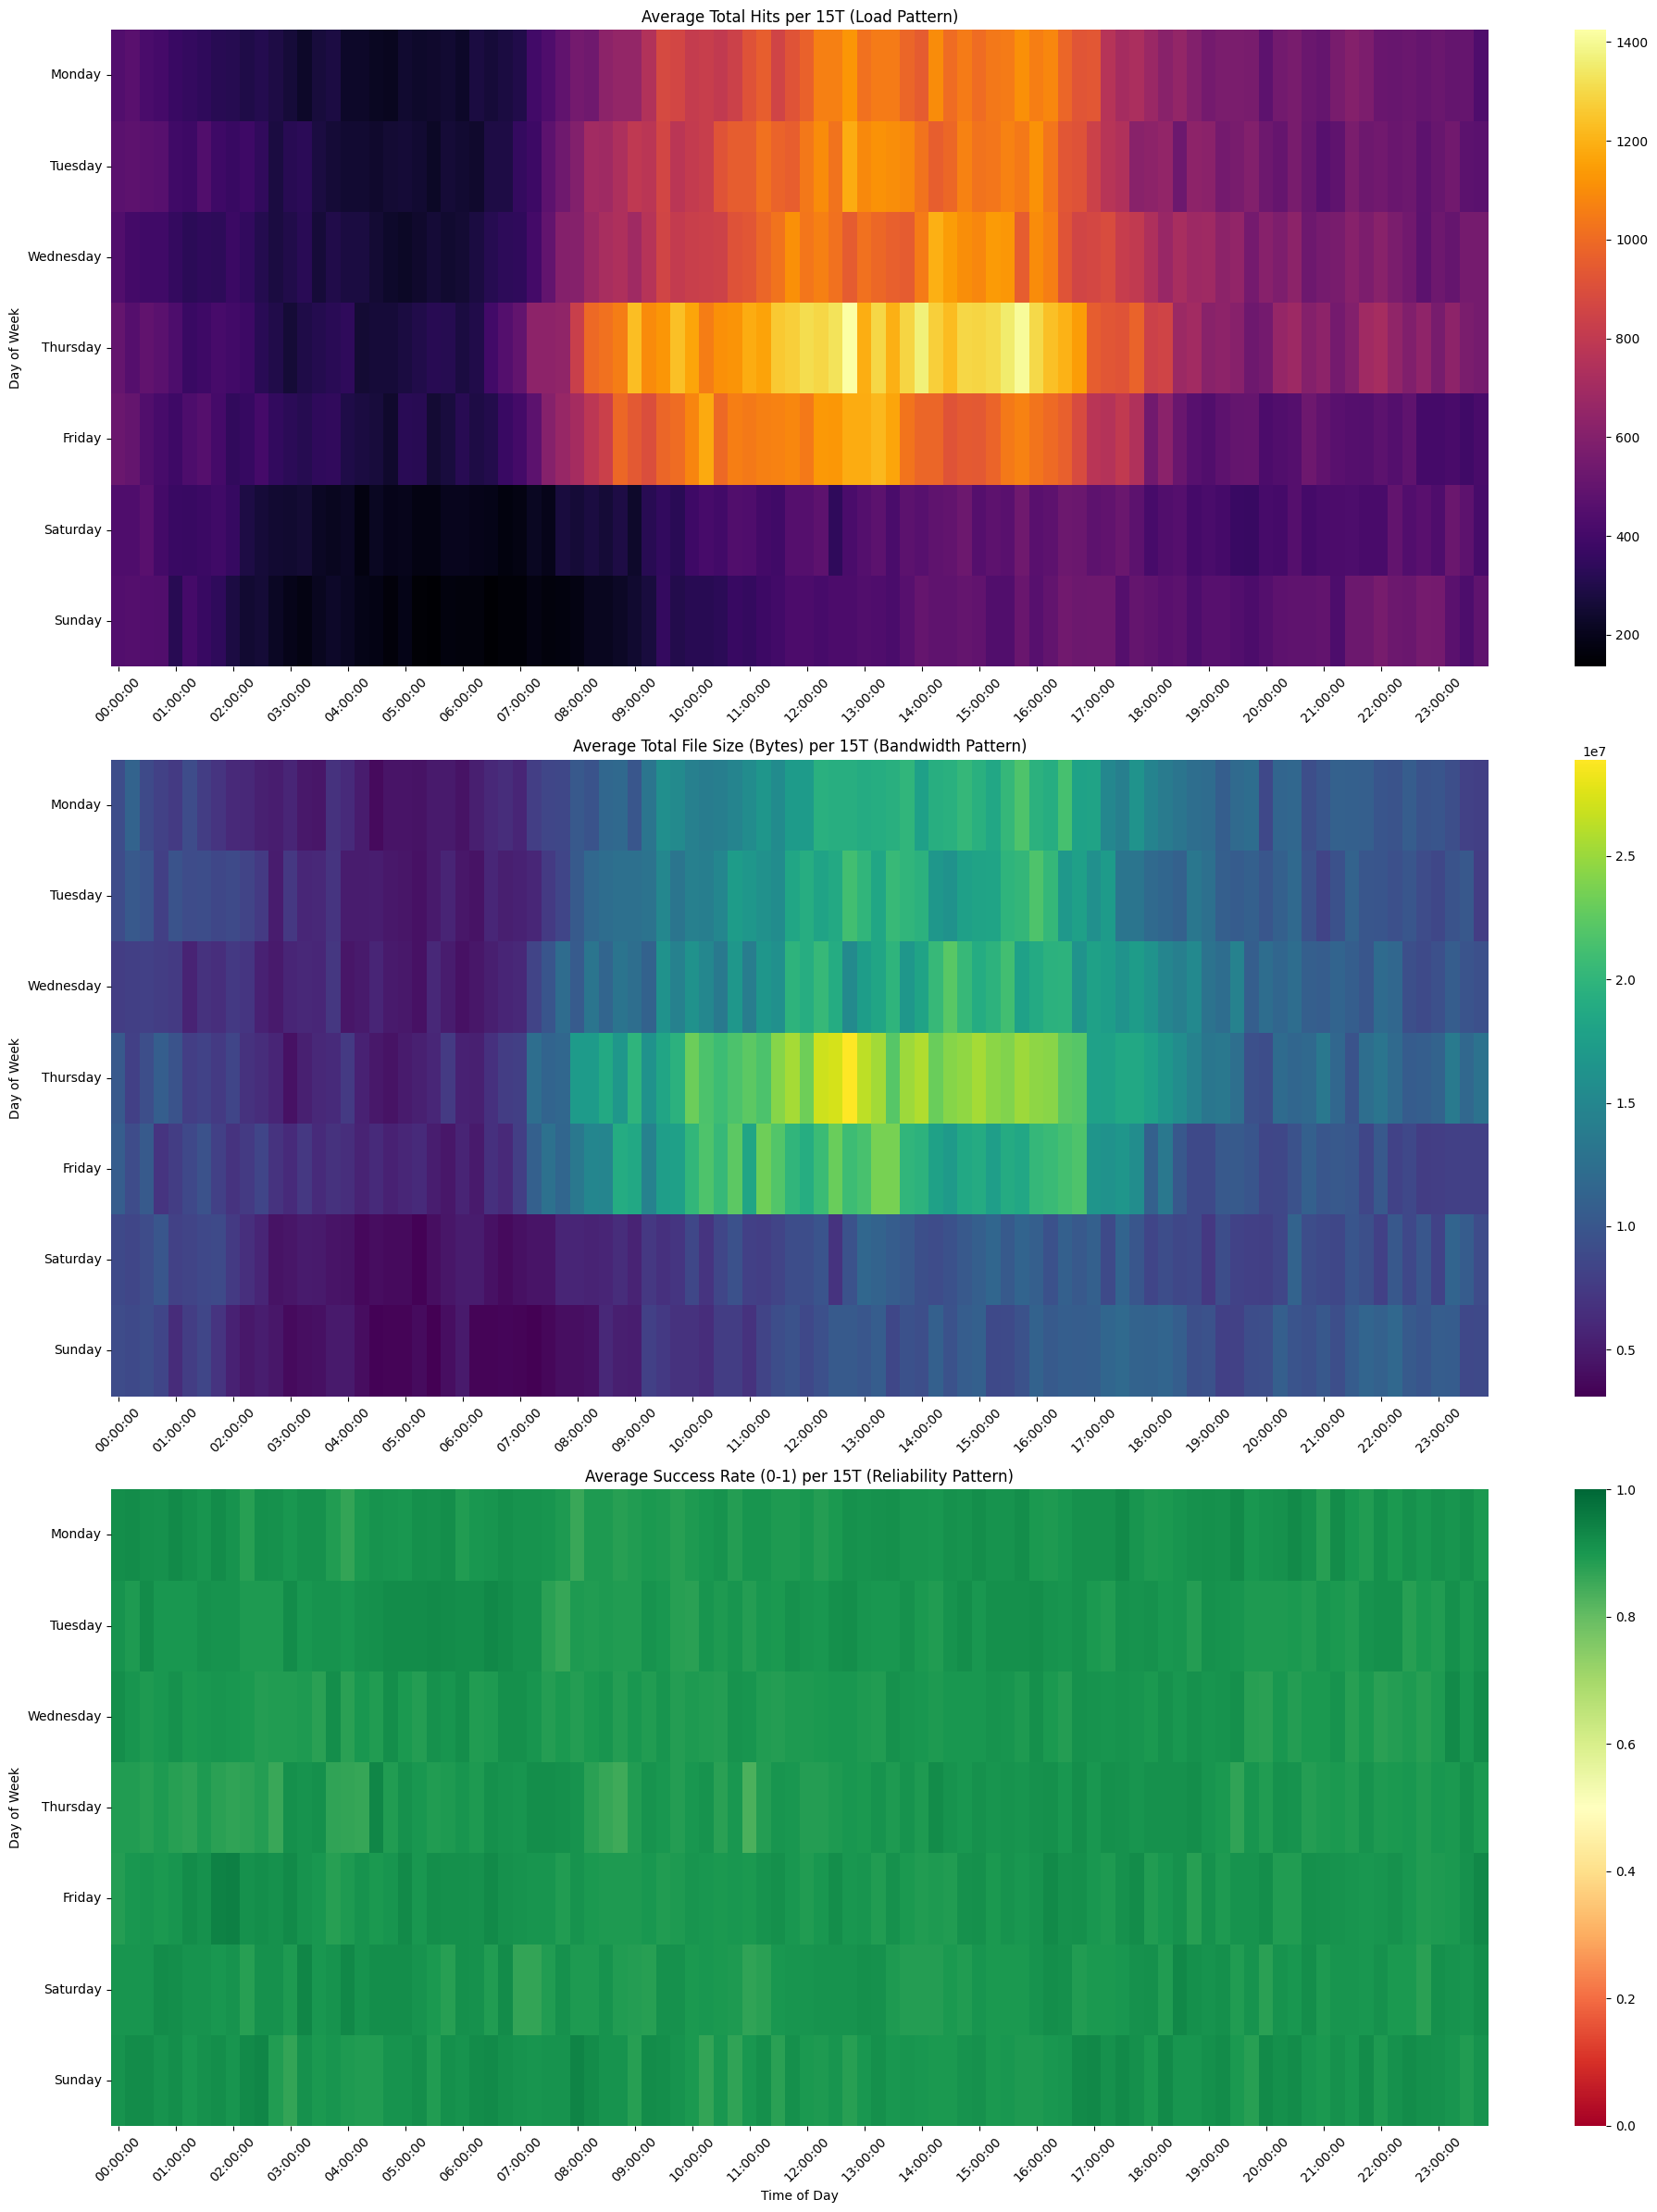

In [11]:
from plot_utils import plot_weekly_patterns

# plot_weekly_patterns(df, interval='1H', figsize=(20, 24))
# plot_weekly_patterns(df, interval='30T', figsize=(20, 24))
plot_weekly_patterns(df, interval='15T', figsize=(20, 24))


#### Mean success ratio, total file size, total hits time of day (line plots)

Generating daily profile (Time of Day analysis) for 10T interval...


/Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/Meine Ablage/03_PersonalWork/FomoKaguya2026/eda/plot_utils.py:219: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = df.resample(interval)
/Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/Meine Ablage/03_PersonalWork/FomoKaguya2026/eda/plot_utils.py:227: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts_success = df[df['status_label'] == 'Success'].resample(interval).size()


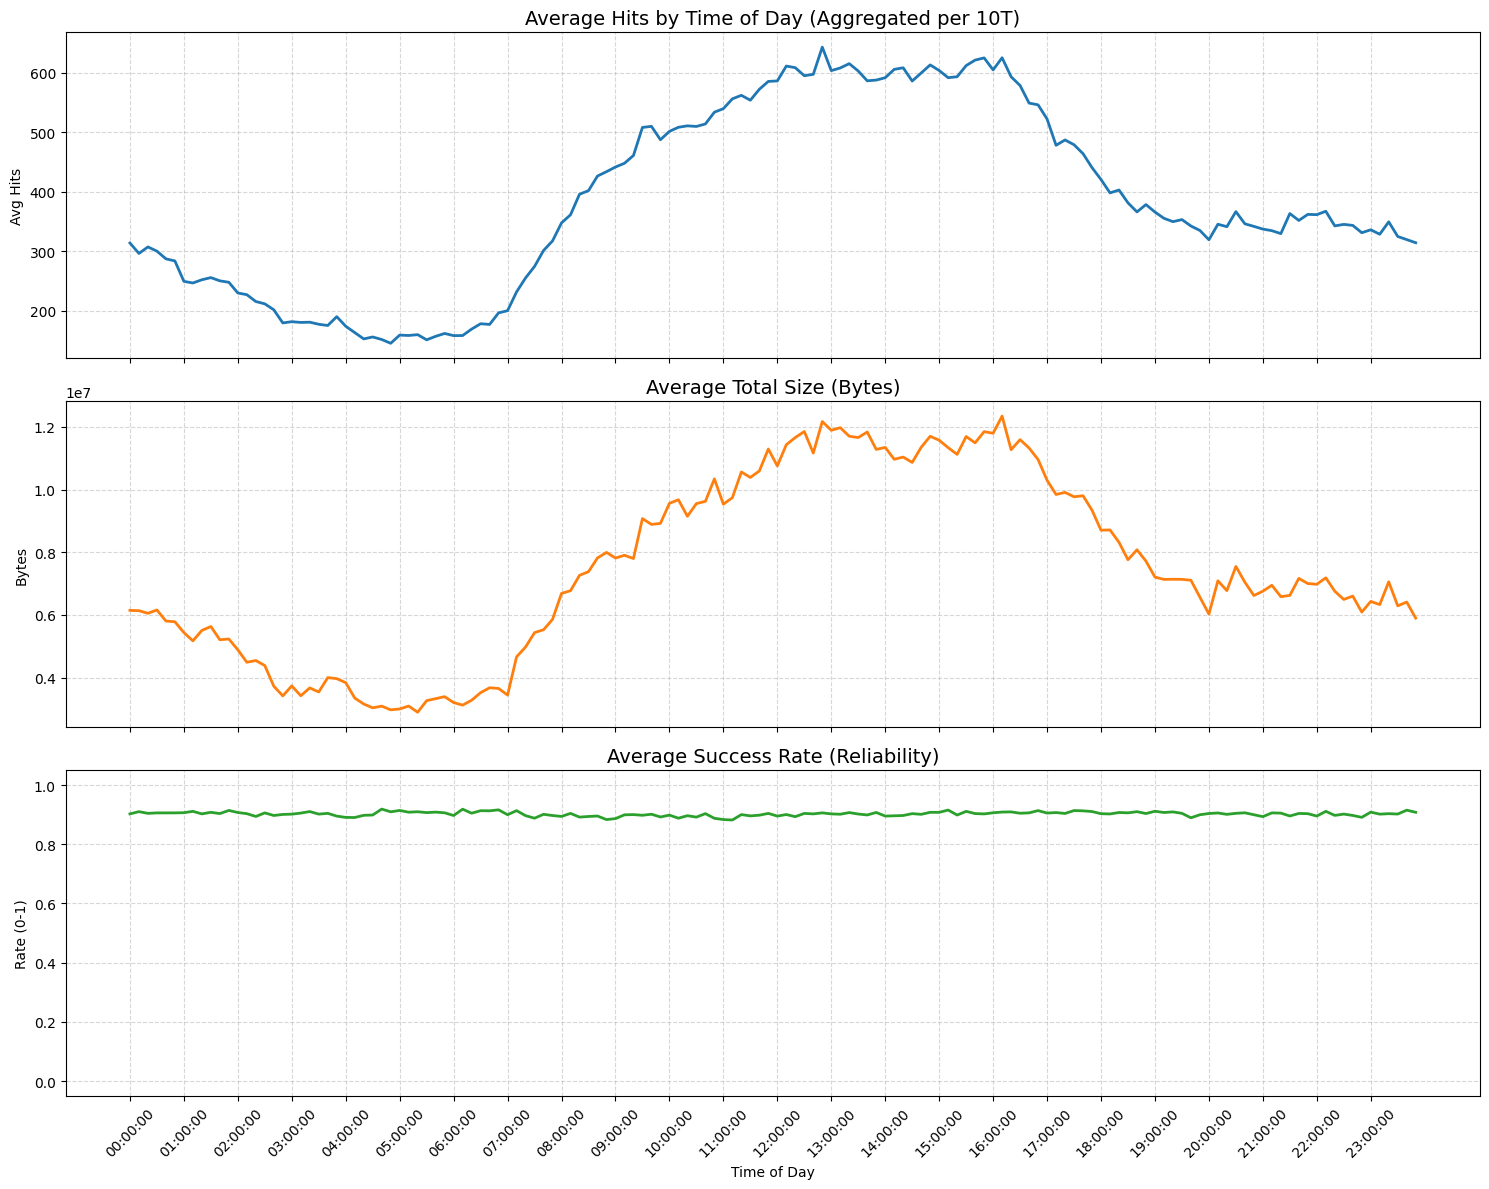

In [31]:
from plot_utils import plot_daily_profile

# See the average daily pattern (e.g. morning peak, lunch dip, etc.)
plot_daily_profile(df, interval='10T')

### Traffic Characteristics

#### Analyse status distribution


--- Analysis for 1min Interval ---


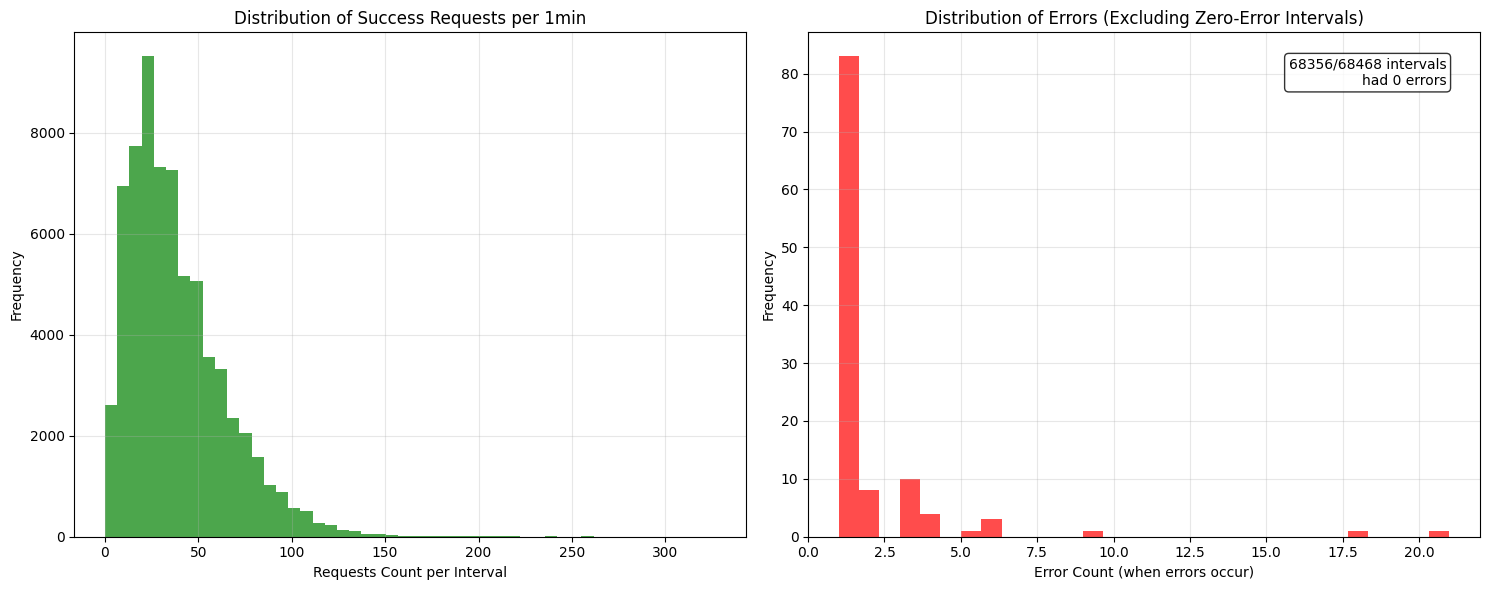

Stats for 1min:


status_label,Success,Error
count,68468.000000,68468.000000
mean,38.593372,0.003155
std,26.319122,0.134973
min,0.000000,0.000000
25%,19.000000,0.000000
50%,33.000000,0.000000
75%,52.000000,0.000000
max,327.000000,21.000000



--- Analysis for 5min Interval ---


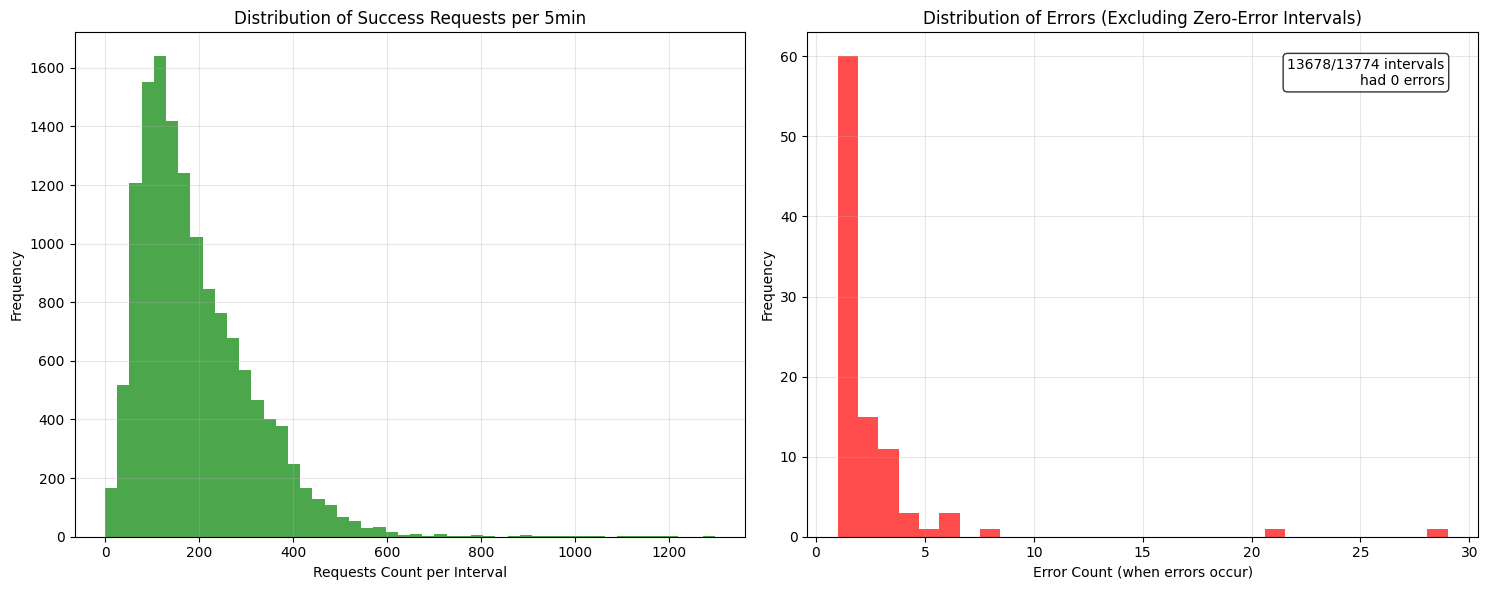

Stats for 5min:


status_label,Success,Error
count,13774.000000,13774.000000
mean,191.840497,0.015682
std,120.199392,0.355702
min,0.000000,0.000000
25%,104.000000,0.000000
50%,163.000000,0.000000
75%,258.000000,0.000000
max,1298.000000,29.000000



--- Analysis for 15min Interval ---


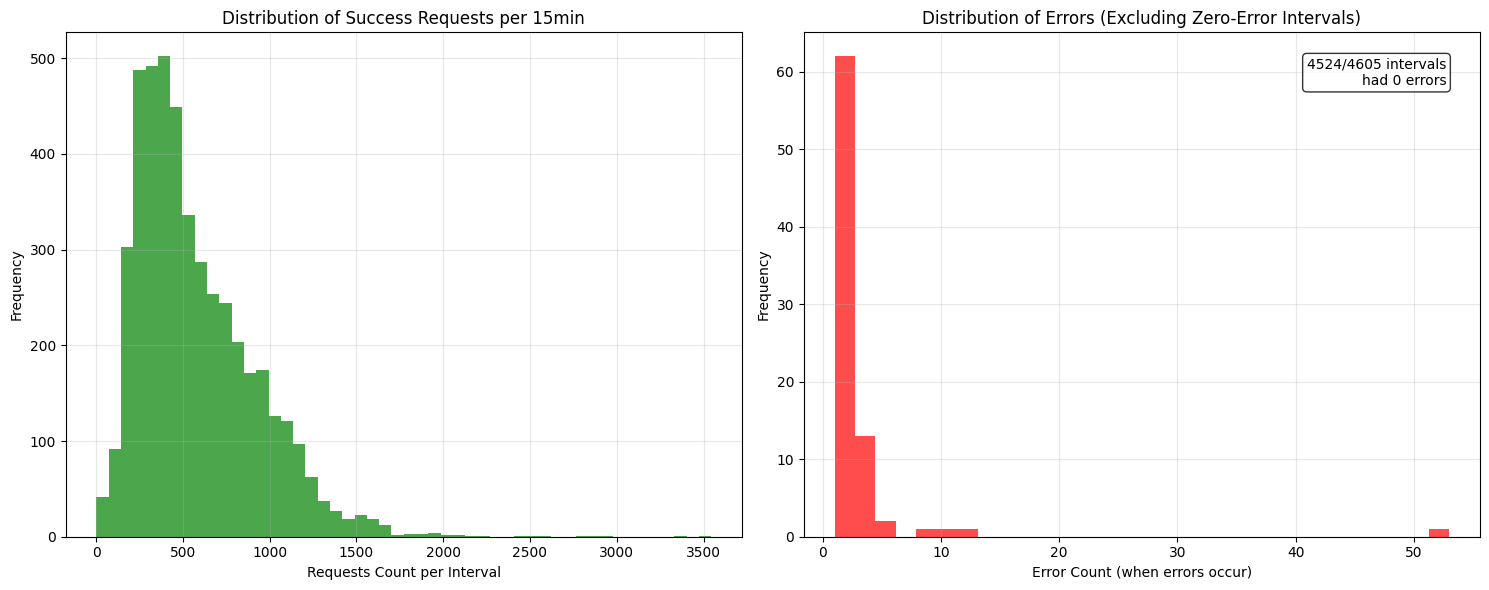

Stats for 15min:


status_label,Success,Error
count,4605.000000,4605.000000
mean,573.813464,0.046906
std,347.718571,0.866134
min,1.000000,0.000000
25%,317.000000,0.000000
50%,488.000000,0.000000
75%,772.000000,0.000000
max,3544.000000,53.000000


In [13]:
from plot_utils import analyze_status_distribution

analyze_status_distribution(df)

#### Top 10 domains that send the most request

In [14]:
# top_10 = df.groupby('ip').select_dtypes(include=np.number).aggregate(sum).sort_values().head(10)
top_10 = df.groupby('ip').sum(numeric_only=True).sort_values('size', ascending=False).head(10)

In [15]:
top_10

,size
ip,
piweba3y.prodigy.com,487716948.0
piweba1y.prodigy.com,306664268.0
piweba4y.prodigy.com,296228124.0
news.ti.com,251958545.0
alyssa.prodigy.com,214450314.0
e659229.boeing.com,182149886.0
piweba2y.prodigy.com,177928426.0
163.206.137.21,159648442.0
poppy.hensa.ac.uk,159362257.0


#### Line plot over time of 10 domains that sends the most number of request

### Contextual Analysis (what is requested)

#### what types of resources that are popular

Analyzing File Types...


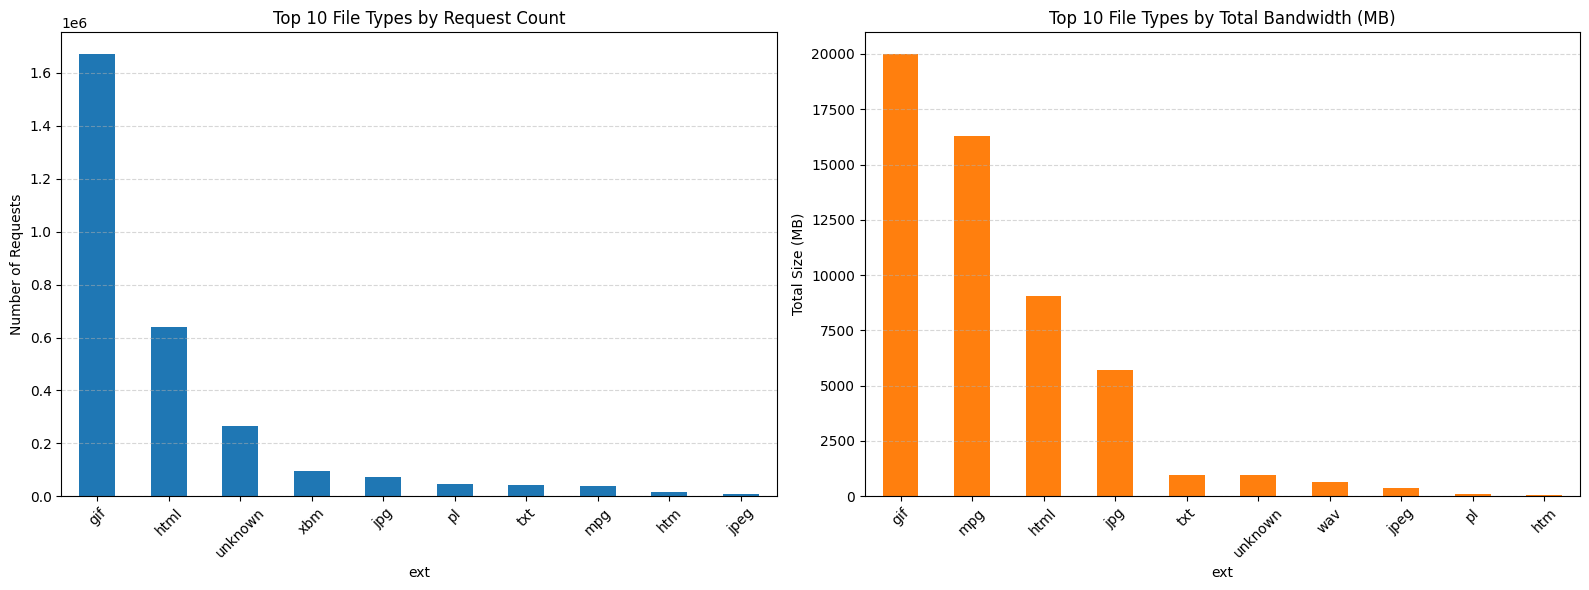

In [16]:
from plot_utils import plot_file_type_stats

plot_file_type_stats(df)

#### Top most active IPs (most request and most data downloaded)

Identifying Top 10 Users...


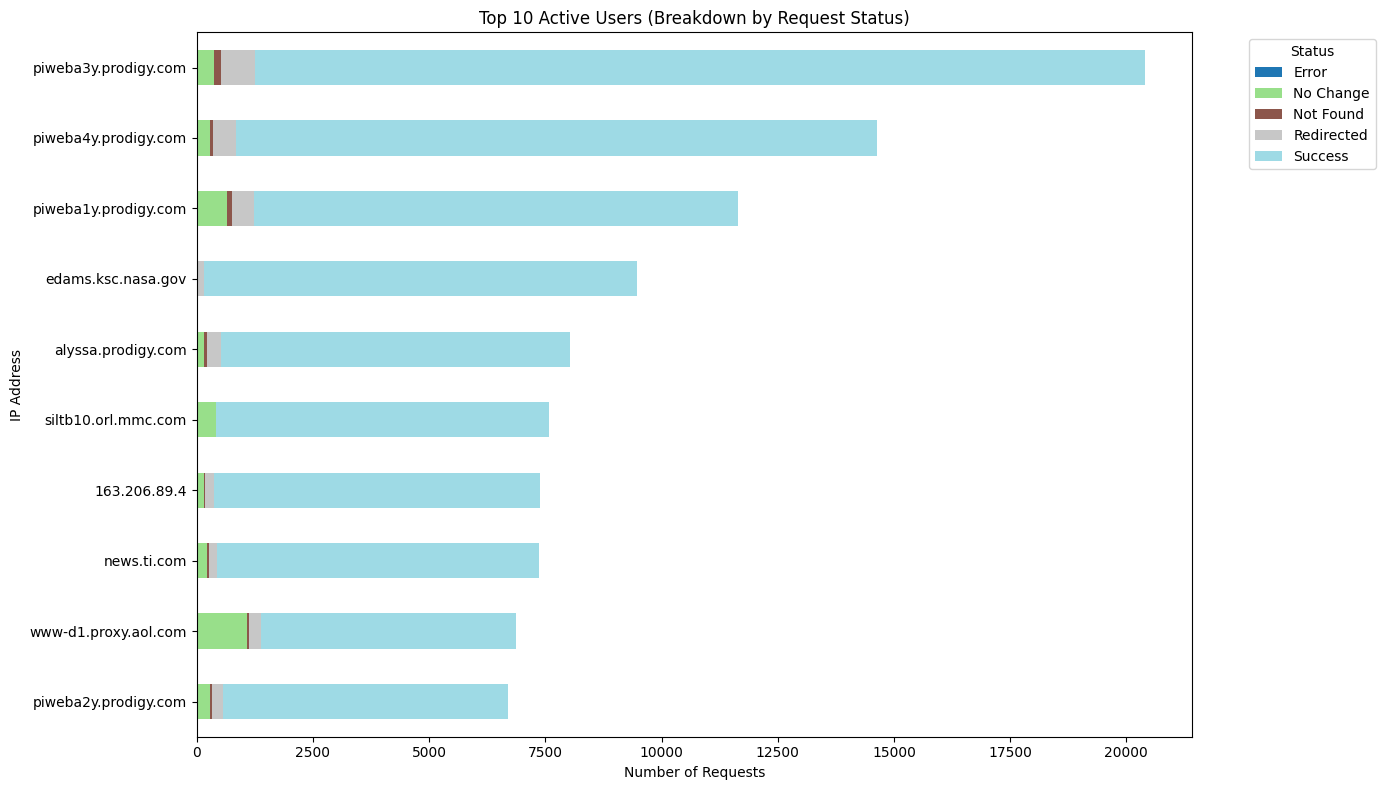

In [17]:
from plot_utils import plot_top_users

plot_top_users(df)

#### Status distribution breakdown

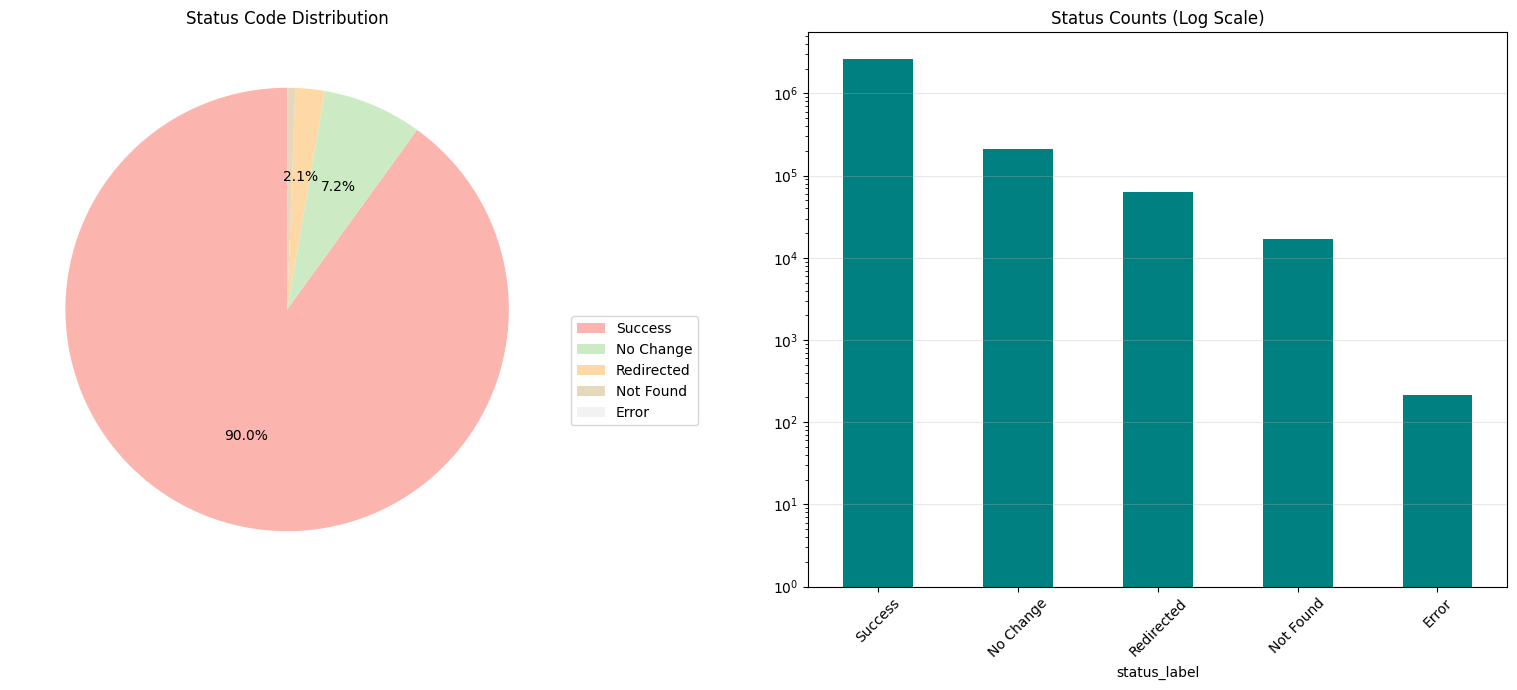

In [18]:
from plot_utils import plot_status_breakdown

plot_status_breakdown(df)


### Bonus

#### Rolling mean

Calculating Rolling Statistics (window=1H)...


<string>:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
<string>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


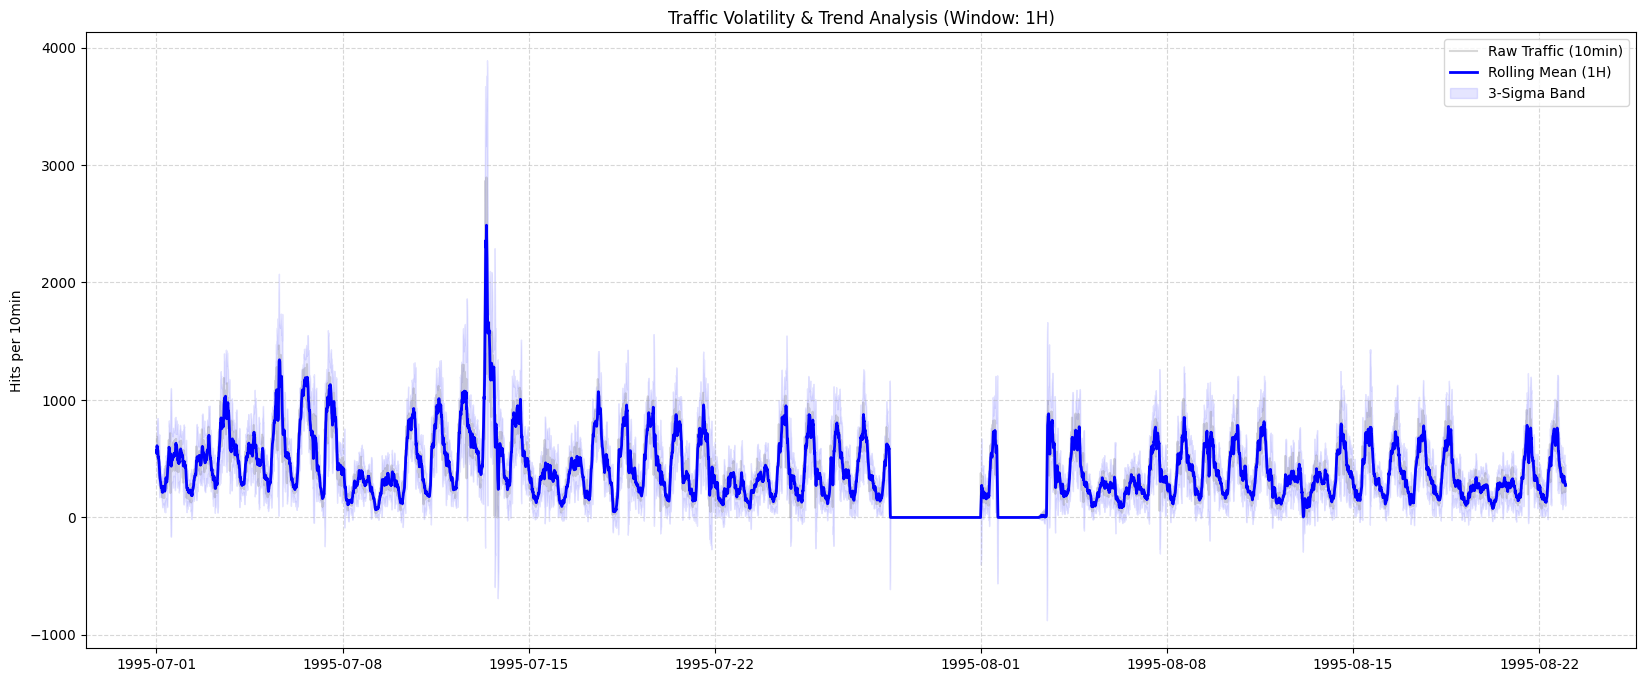

In [19]:
from plot_utils import plot_rolling_statistics

plot_rolling_statistics(df, window='1H')


#### Anamoly

Detecting Anomalies...


<string>:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.


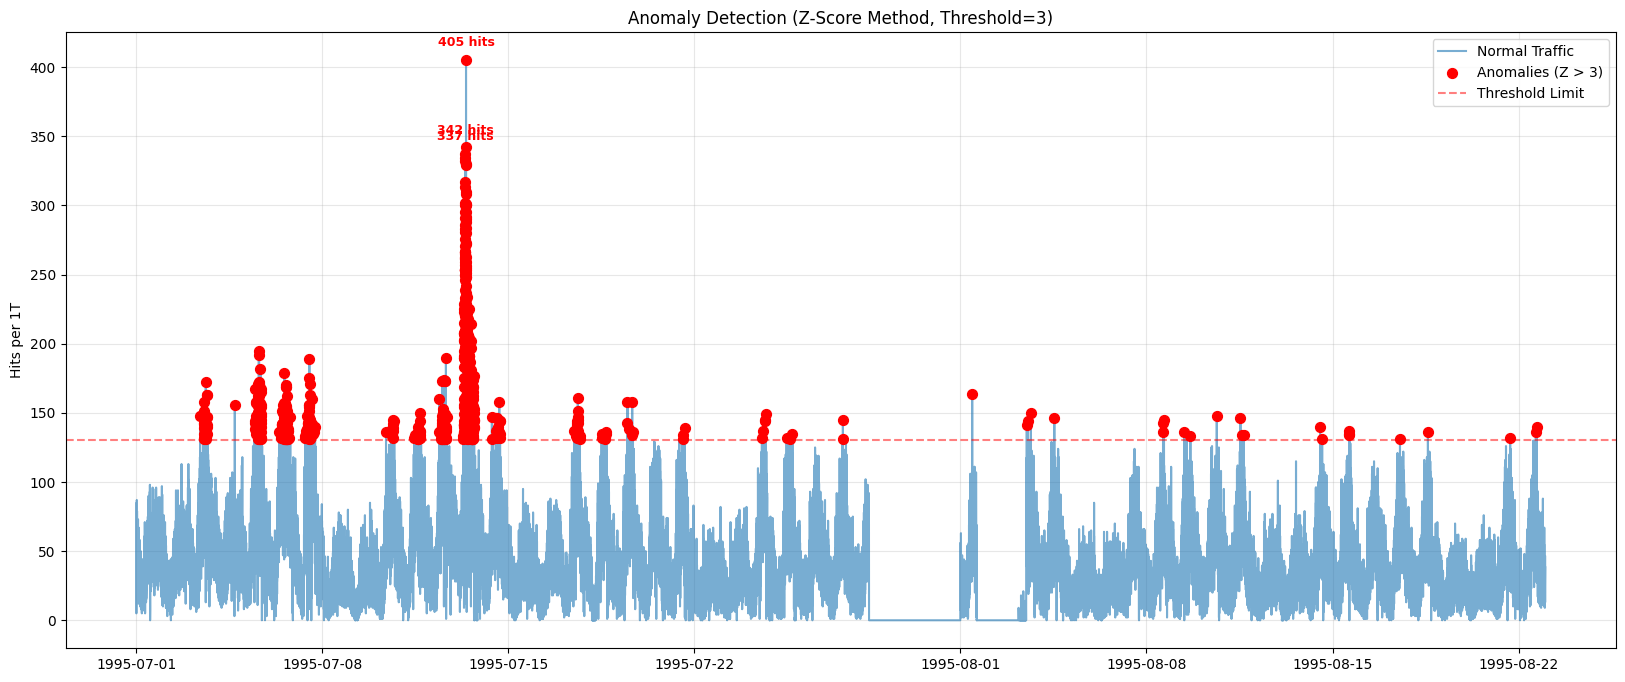

In [27]:
from plot_utils import plot_anomaly_spikes

plot_anomaly_spikes(df, interval='1T', threshold_z=3)


Detecting Anomalies...


<string>:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.


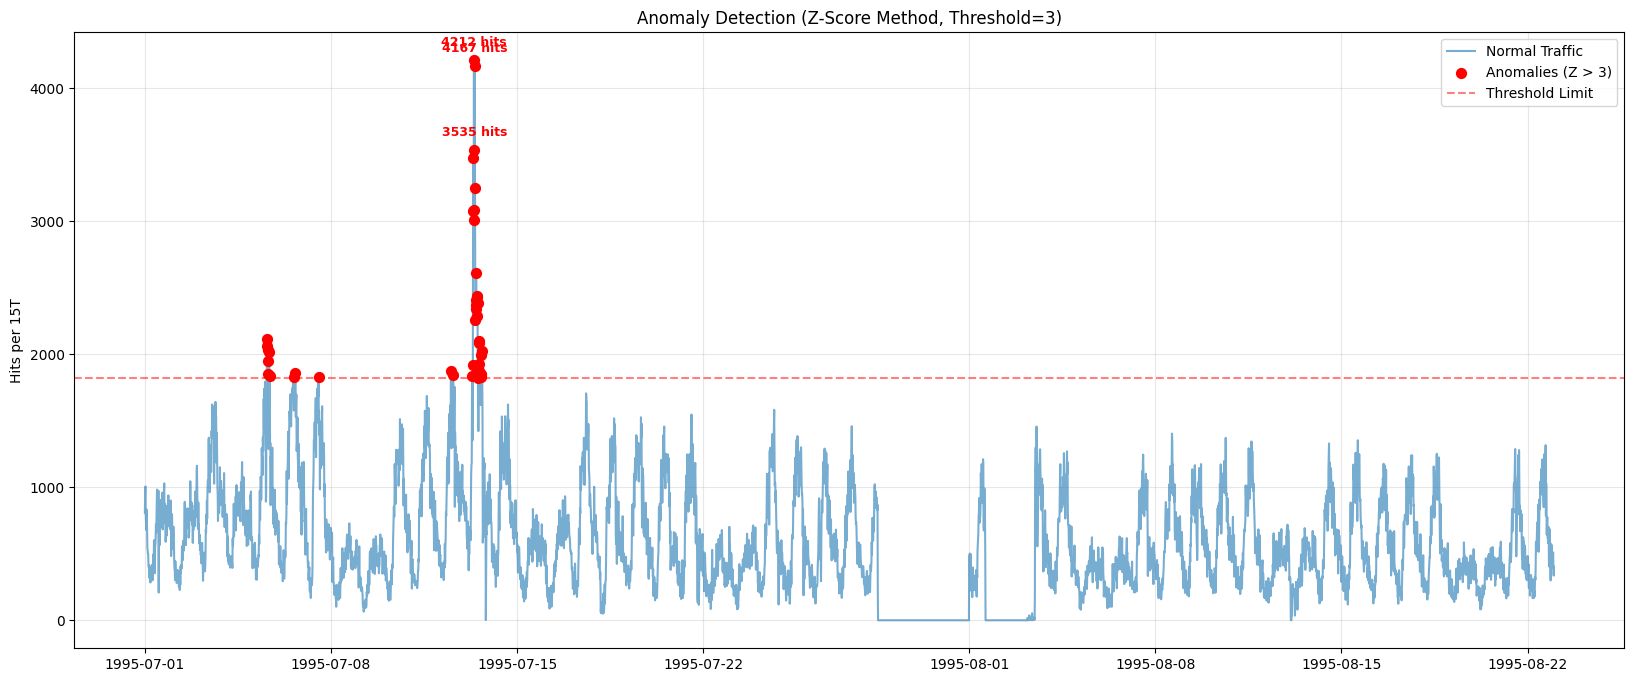

In [28]:
plot_anomaly_spikes(df, interval='15T', threshold_z=3)

Detecting Anomalies...


<string>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


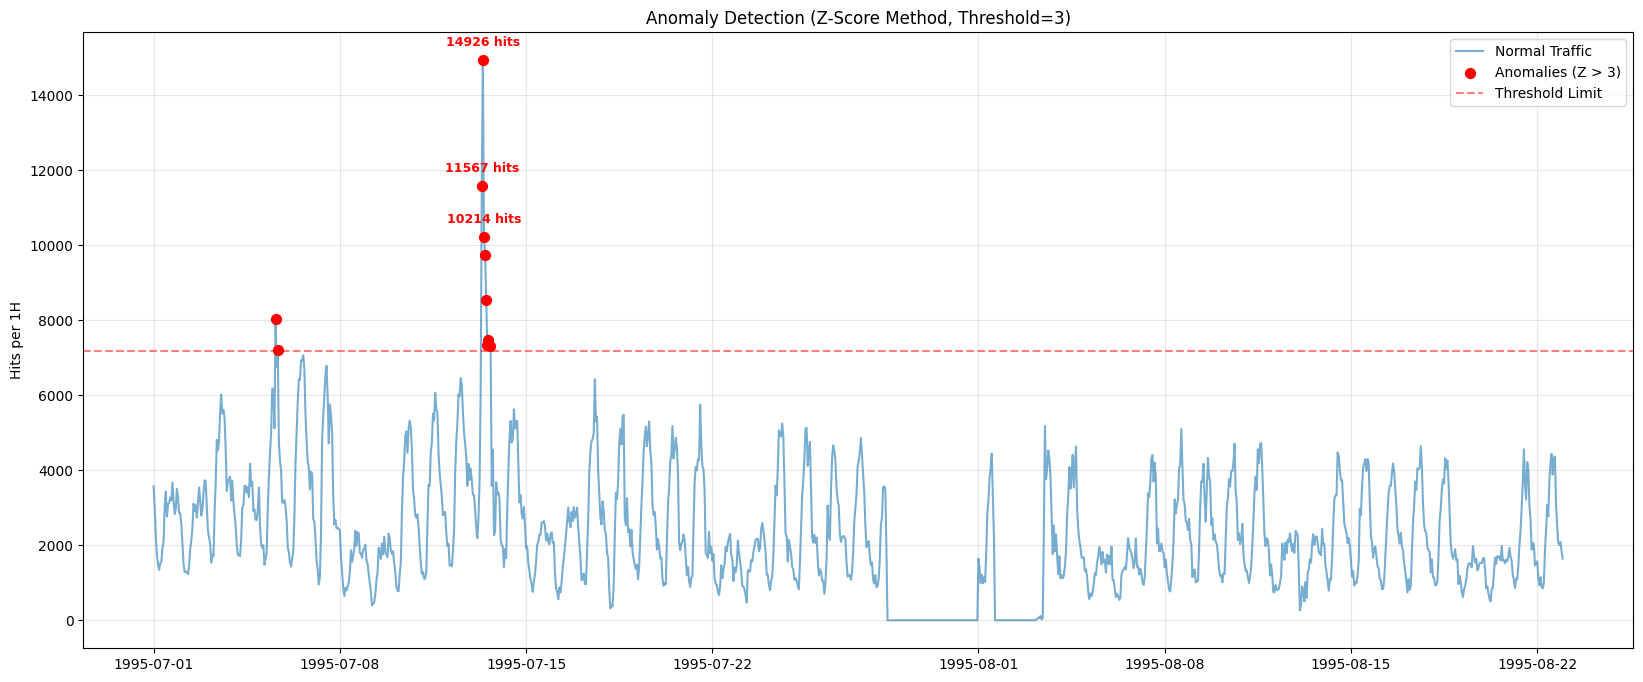

In [29]:
plot_anomaly_spikes(df, interval='1H', threshold_z=3)

### Contents and Reliability

#### Stacked Area Chart (volume of each status code over time, stacked on top of each other)

Calculating Status Evolution (interval=1D)...


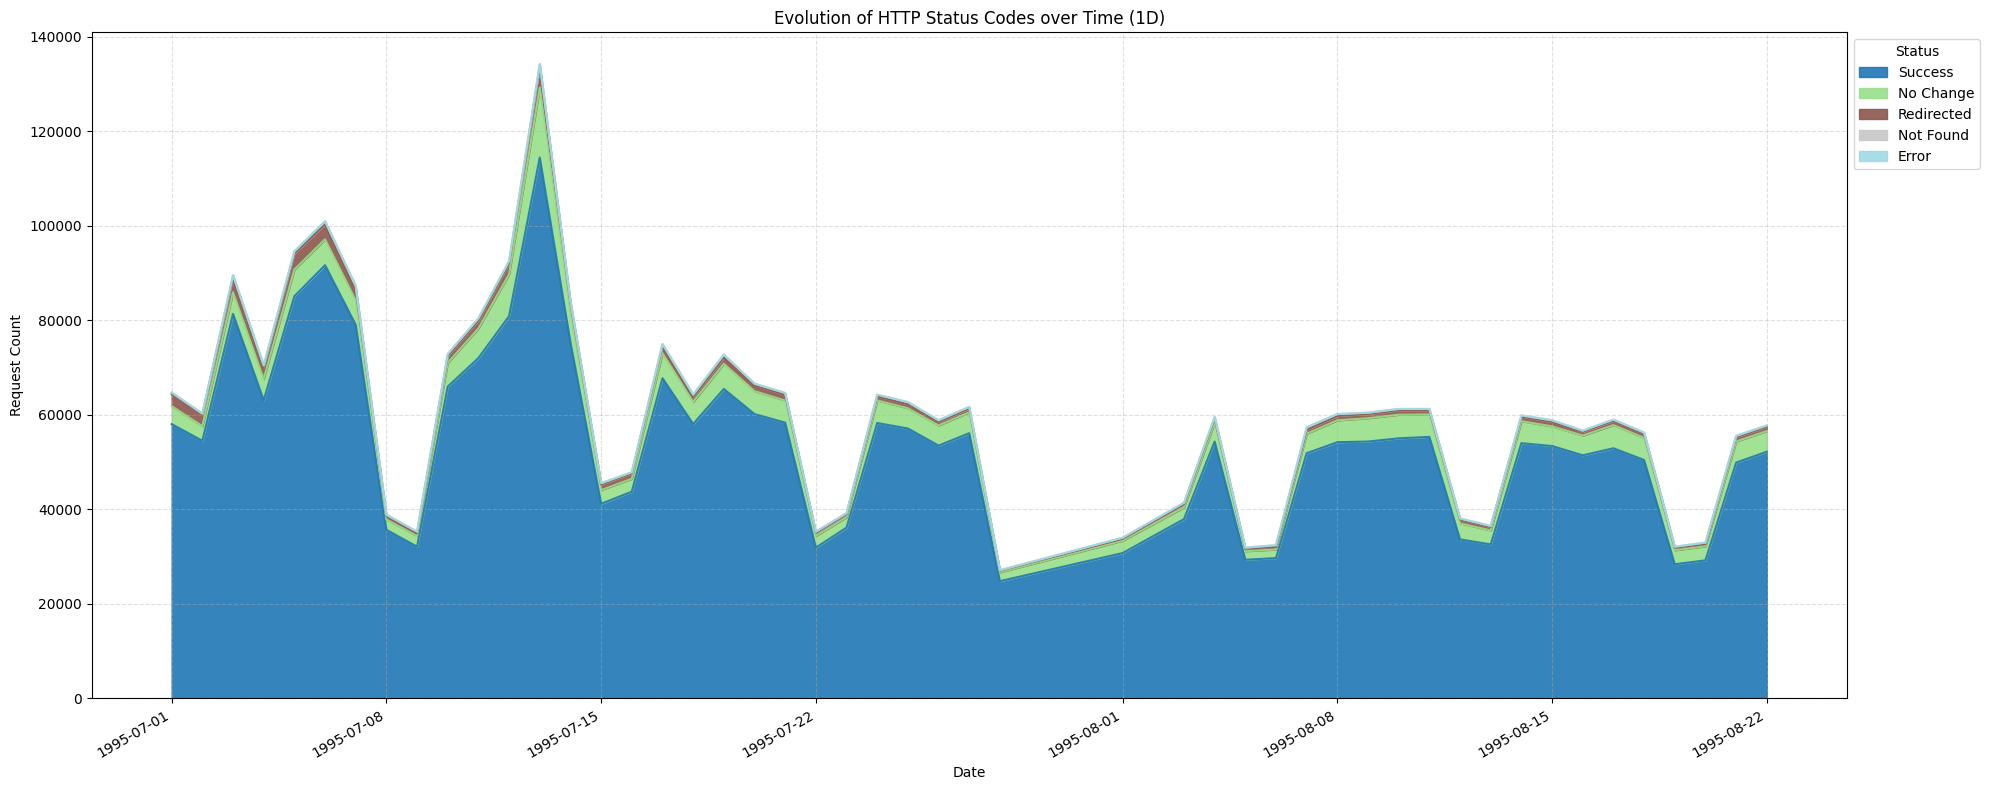

In [32]:
from plot_utils import plot_status_evolution

plot_status_evolution(df)


#### File size histogram log scale

Analyzing Response Size Distribution...


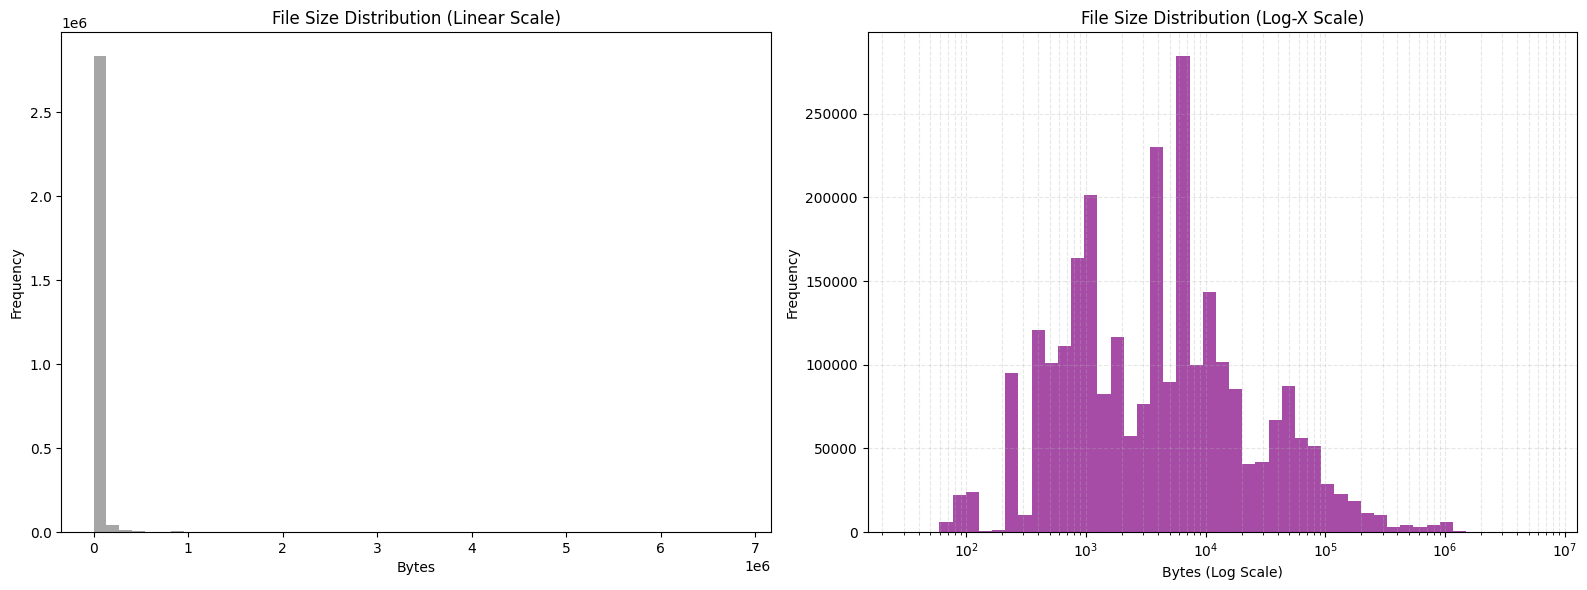

Zero-byte responses: 223474 (7.6%)
Small files (<1KB): 882297 (30.1%)
Large files (>1MB): 3885 (0.1%)


In [33]:
from plot_utils import plot_size_distribution

plot_size_distribution(df)


In [ ]:
####